In [29]:
import FalseColor.Color as fc
import numpy as np
import os
%matplotlib inline
import matplotlib.pyplot as plt
import h5py as h5
import scipy.ndimage as nd
from numba import cuda
import math
import skimage as sk
import cv2
import copy
import time

In [2]:
#method for viewing images
def ViewImage(Images,title=None,do_hist = False,
              figsize = (6,4), range_min=0,
              range_max=None,cmap='viridis'):
    if do_hist:
        f,ax = plt.subplots(ncols = 2,figsize = figsize)
        ax[0].imshow(Images)
        ax[0].set_title('Image')
        if range_max is None:
            range_max = Images.max()
        ax[1].hist(Images[Images != 0].ravel(),256,[range_min,range_max])
        ax[1].set_title('Histogram')
        if title is not None:
            f.suptitle(title)
    else:
        f,ax = plt.subplots(figsize=figsize)
        ax.imshow(Images,cmap=cmap)
        if title is not None:
            ax.set_title(title)
    return f,ax

In [3]:
#load example data
lung_datapath = 'h5_sample_data/lung'
lung_datafile = os.path.join(lung_datapath,'lung_data.h5')
lung_h5 = h5.File(lung_datafile,'r')

In [4]:
#get individual channels
lung_nuclei = lung_h5['t00000']['s00']['0']['cells'][:].astype(float)
lung_cyto = lung_h5['t00000']['s01']['0']['cells'][:].astype(float)
print(lung_nuclei.shape)

(17, 1024, 1024)


(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1d25d492be0>)

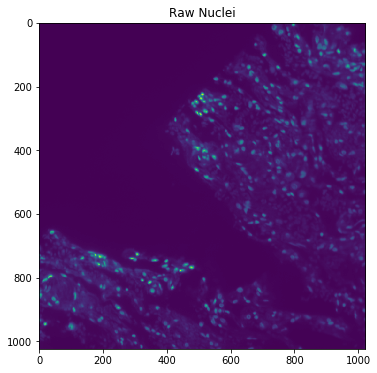

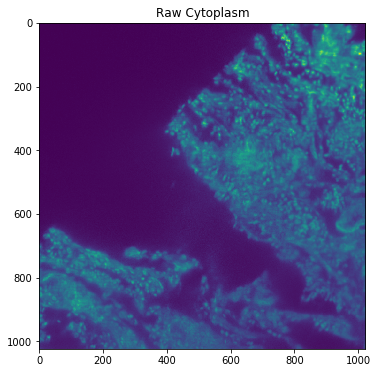

In [40]:
#View raw data
ViewImage(lung_nuclei[0], title = 'Raw Nuclei', figsize = (6,6))
ViewImage(lung_cyto[0], title = 'Raw Cytoplasm', figsize = (6,6))

In [33]:
#Get RGB color settings
settings_dict = fc.getDefaultRGBSettings()
nuclei_RGBsettings = settings_dict['nuclei']
cyto_RGBsettings = settings_dict['cyto']

In [45]:
#execute GPU accelerated false coloring on two individual images using standard background subtraction
example_nuclei = copy.deepcopy(lung_nuclei[0])
example_cyto = copy.deepcopy(lung_cyto[0])

sharpened_nuclei = fc.sharpenImage(example_nuclei)
sharpened_cyto = fc.sharpenImage(example_cyto)

pseudo_lung = fc.rapidFalseColor(sharpened_nuclei, sharpened_cyto, nuclei_RGBsettings, cyto_RGBsettings,
                                       run_FlatField_cyto = False, run_FlatField_nuc = False,
                                       cyto_normfactor = 1200, 
                                       nuc_normfactor = 9000)


(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1d25d462860>)

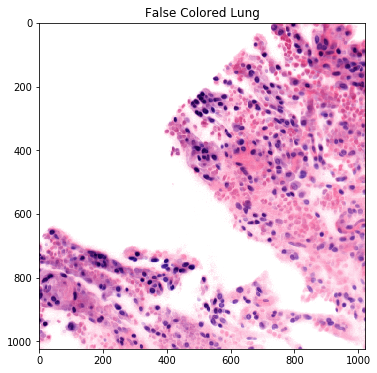

In [46]:
#View Result
ViewImage(pseudo_lung, title='False Colored Lung',figsize=(6,6))


Below will use the flat fielding method, the non default option for fc.rapidFalseColor


In [22]:
# subtract background from images
nuclei_nobackground = np.zeros(lung_nuclei.shape)
cyto_nobackground = np.zeros(lung_cyto.shape)

for i in range(len(lung_nuclei)):
    nuc_bg = fc.getBackgroundLevels(lung_nuclei[i])[1]
    cyto_bg = fc.getBackgroundLevels(lung_cyto[i])[1]
    
    nuc_img = copy.deepcopy(lung_nuclei[i]) - nuc_bg
    nuc_img[nuc_img < 0] = 0
    
    cyto_img = copy.deepcopy(lung_cyto[i]) - cyto_bg
    cyto_img[cyto_img < 0] = 0
    
    nuclei_nobackground[i] = nuc_img
    cyto_nobackground[i] = cyto_img

In [23]:
#Calculate flatfield from background subtracted data
nuc_flatfield = fc.getFlatField(nuclei_nobackground)[0]
cyto_flatfield = fc.getFlatField(cyto_nobackground)[0]

In [24]:
#upsample flat fields to be the correct shape
nuc_flatfield = nd.interpolation.zoom(nuc_flatfield[0], 16, order = 1, mode = 'nearest')
cyto_flatfield = nd.interpolation.zoom(cyto_flatfield[0], 16, order = 1, mode = 'nearest')
nuc_flatfield.shape

(1024, 1024)

In [25]:
#Sharpen Images
sharp_nuclei = np.zeros(nuclei_nobackground.shape)
sharp_cyto = np.zeros(cyto_nobackground.shape)

for i in range(len(sharp_nuclei)):
    sharp_nuclei[i] = fc.sharpenImage(nuclei_nobackground[i])
    sharp_cyto[i] = fc.sharpenImage(cyto_nobackground[i])

In [26]:
#get RGB settings for flat fielding method
settings_dict = fc.getDefaultRGBSettings()

In [27]:
#execute false coloring for whole dataset using flat fielding method
pseudo_colored = []
tstart = time.time()
for i in range(len(lung_nuclei)):
    pseudo_colored.append(fc.rapidFalseColor(sharp_nuclei[i], sharp_cyto[i], nuclei_RGBsettings, cyto_RGBsettings,
                                            run_FlatField_nuc = True, run_FlatField_cyto = True
                                            nuc_normfactor = nuc_flatfield,
                                            cyto_normfactor = 3*cyto_flatfield))
print(time.time()-tstart)

2.5944151878356934


(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1d249adbe10>)

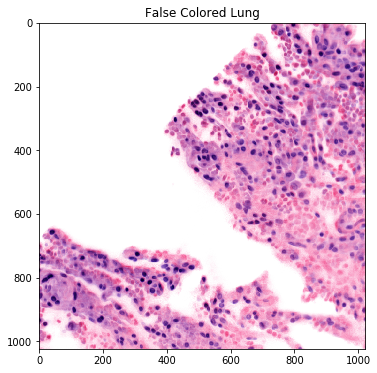

In [42]:
ViewImage(pseudo_colored[0],title = 'False Colored Lung', figsize=(6,6))